In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from utils import read_air_passengers_csv, train_val_test_split
from modules import LSTMNet

YEAR_CUTOFFS = [1940, 1956, 1960]

# Long Short-Term Memory (LSTM) net

In this notebook, I explore a well-known artificial neural network (ANN) which is often used for natural language processing (NLP) problems, but also for time-series analysis (TSA) tasks. In particular, it is a recurrent neural network (RNN), which means that it uses a recurrent state, which is updated with new inputs on an iterative manner.

Basically, the LSTM cell gets the input $x_t$ together with the recurrent state $h_{t-1}$, and outputs the new recurrent state $h_t$. From this recurrent state, the prediction $y_t$ can be made. See the image below, by Victor Roman (https://towardsdatascience.com/recurrent-neural-networks-56e1ad215339/).

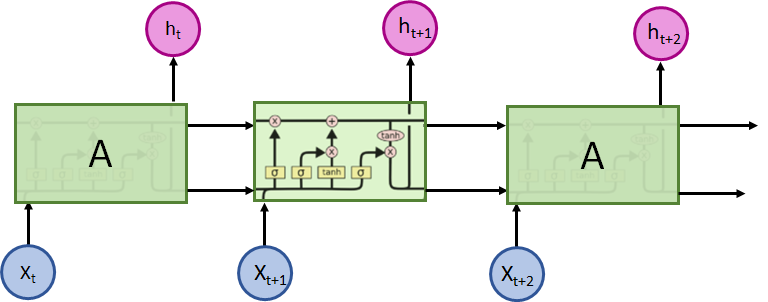

Of course, the theory is a bit more complicated, but the idea is that I can define a sequence, say $[x_{t-2}, x_{t-1}, x_t]$ from which to predict $[y_{t-2}, y_{t-1}, y_t]$. For this specific problem of time-series analysis, it makes sense to provide sequences shifted by 1 step of time, that is, if my input sequence is $[y_{t-2}, y_{t-1}, y_t]$, my prediction is supposed to be $[y_{t-1}, y_t, y_{t+1}]$. With this, after my model is trained, I will just have to filter the last value, which is indeed the prediction value I'm looking for. This trick needs to be done because of the design of the LSTM, which outputs a sequence of the same length as the input.

As always, I prepare the data :

In [291]:
df = read_air_passengers_csv()
df_train, df_val, df_test = train_val_test_split(df, YEAR_CUTOFFS)
df_train = df_train.dropna()

# Transform from pandas dataframe to numpy array of shape (n, 1)
train_0 = df_train[["#Passengers"]].values
val_0 = df_val[["#Passengers"]].values

In [292]:
train_months = np.arange(len(train_0)).reshape(-1, 1)
val_months = np.arange(len(train_0), len(train_0) + len(val_0)).reshape(-1, 1)

n_months = 36

lin_reg = LinearRegression()
lin_reg = lin_reg.fit(train_months[-n_months:], train_0[-n_months:])
train_fit = lin_reg.predict(train_months)
val_fit = lin_reg.predict(val_months)

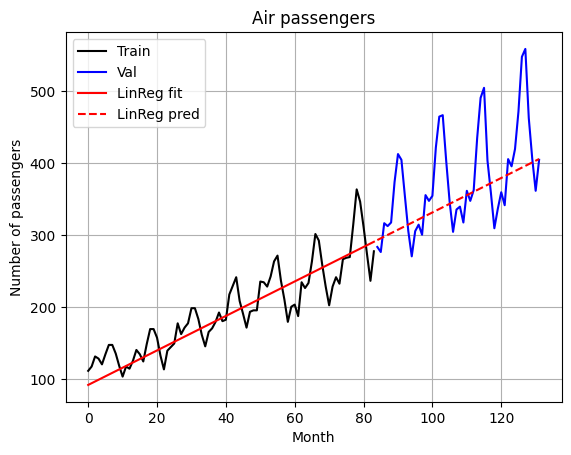

In [293]:
plt.title("Air passengers")
plt.xlabel("Month")
plt.ylabel("Number of passengers")
plt.plot(train_0, color="k", label="Train")
plt.plot(
    np.arange(len(train_0), len(train_0) + len(val_0)), val_0, color="b", label="Val"
)
plt.plot(train_fit, c="r", label="LinReg fit")
plt.plot(val_months, val_fit, c="r", linestyle="dashed", label="LinReg pred")

plt.grid()
plt.legend()
plt.show()

In [294]:
train = train_0 - train_fit
val = val_0 - val_fit

In [295]:
# Normalize the data
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
val = scaler.fit_transform(val)

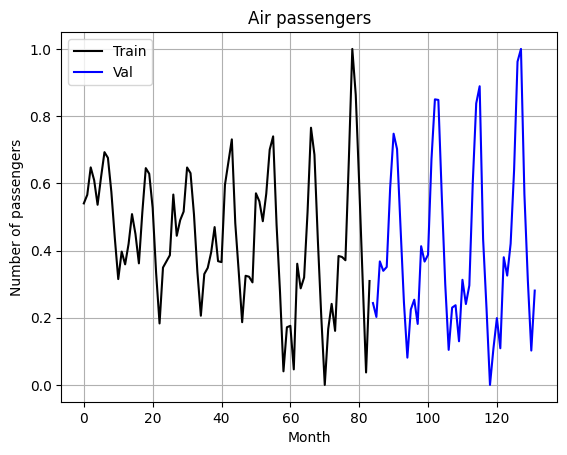

In [296]:
plt.title("Air passengers")
plt.xlabel("Month")
plt.ylabel("Number of passengers")
plt.plot(train, color="k", label="Train")
plt.plot(np.arange(len(train), len(train) + len(val)), val, color="b", label="Val")

plt.grid()
plt.legend()
plt.show()

In [297]:
train = train.astype("float32")
val = val.astype("float32")

# (1) First attempt

Let's define a function that prepares the data sequences. What I'm trying to achieve is, from a full time-series set such as my `train` array, a pair of `torch` tensors consisting of corresponding sequences. The length of my sequences will be called `look_back`, as it can be thought of the number of past values that my LSTM needs to predict a new value. I will start with `look_back = 4` in this first attempt (which will probably lead to bad results, as it won't be able to learn the seasonal effects).

For example, if my array `train` contains $[y_0, y_1, y_2, y_3, y_4, ...]$, I want my output to be $X = [[y_0, y_1, y_2, y_3], [y_1, y_2, y_3, y_4], ...]$ and $y = [[y_1, y_2, y_3, y_4], [y_2, y_3, y_4, y_5], ...]$. Notice how the first element of $X$ is the input sequence from which the LSTM will predict the first element of $y$.

In [298]:
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        feature = data[i : i + look_back]
        target = data[i + 1 : i + look_back + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [299]:
# Constants

look_back = 4
recurrent_size = 50
n_layers = 1

batch_size = 8

n_epochs = 2500
n_epochs_eval = n_epochs / 10

In [300]:
X_train, y_train = create_dataset(data=train, look_back=look_back)
print(X_train.shape, y_train.shape)

X_val, y_val = create_dataset(data=val, look_back=look_back)
print(X_val.shape, y_val.shape)

train_dataloader = DataLoader(
    dataset=TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

torch.Size([80, 4, 1]) torch.Size([80, 4, 1])
torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


With these tensors containing the sequences, I can define a `DataLoader` that pairs them and shuffles them, so that my training loop can iterate over them in no particular order. Also, I set the `batch_size` to 8, as defined above in the constants.

It's important to remind that the input dimension of the LSTM is 1, so is the output. The size of the sequences is set to 4. But each sequence has dimension 1, because it's a vector.

In [301]:
def eval_val(model):
    y_pred_val = torch.zeros(len(val))
    last_values = X_train[-1]

    for i in range(look_back):
        model.eval()
        with torch.no_grad():
            new_pred = model(last_values)[-1]
        last_values = torch.vstack((last_values[1:], new_pred))
        y_pred_val[i] = new_pred

    for i in range(len(val) - look_back):
        last_values = y_pred_val[i : i + look_back].reshape(-1, 1)
        model.eval()
        with torch.no_grad():
            new_pred = model(last_values)[-1]
        y_pred_val[i + look_back] = new_pred

    return y_pred_val

In [302]:
def train_model(train_dataloader, is_dropout=False):

    model = LSTMNet(
        dim_input=1,
        dim_recurrent=recurrent_size,
        num_layers=n_layers,
        dim_output=1,
        is_dropout=is_dropout,
    )

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    list_rmse_train = []
    list_rmse_val = []

    for epoch in range(1, n_epochs + 1):
        # Set model to train mode
        model.train()
        for features, targets in train_dataloader:
            outputs = model(features)
            loss = criterion(outputs, targets)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Evaluation
        if epoch % n_epochs_eval == 0:
            # Set model to eval mode, and disable autograd
            model.eval()
            with torch.no_grad():
                rmse_train = np.sqrt(criterion(model(X_train), y_train))
                list_rmse_train.append(rmse_train)
                y_pred_val = eval_val(model)
                rmse_val = np.sqrt(criterion(y_pred_val, y_val))
                list_rmse_val.append(rmse_val)
                print(
                    f"Epoch {epoch}: RMSE_train = {rmse_train:.2f}, RMSE_val = {rmse_val:.2f}"
                )

    return model, list_rmse_train, list_rmse_val

In [303]:
model, list_rmse_train, list_rmse_val = train_model(train_dataloader)

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([44, 4, 1])) that is different to the input size (torch.Size([48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 250: RMSE_train = 0.11, RMSE_val = 0.29
Epoch 500: RMSE_train = 0.10, RMSE_val = 0.30
Epoch 750: RMSE_train = 0.10, RMSE_val = 0.30
Epoch 1000: RMSE_train = 0.10, RMSE_val = 0.31
Epoch 1250: RMSE_train = 0.09, RMSE_val = 0.32
Epoch 1500: RMSE_train = 0.09, RMSE_val = 0.31
Epoch 1750: RMSE_train = 0.09, RMSE_val = 0.34
Epoch 2000: RMSE_train = 0.09, RMSE_val = 0.32
Epoch 2250: RMSE_train = 0.09, RMSE_val = 0.35
Epoch 2500: RMSE_train = 0.09, RMSE_val = 0.37


In [304]:
def plot_rmse_epochs(list_rmse_train, list_rmse_val, ax=None, label="", last=True):
    x_epochs = np.arange(n_epochs_eval, n_epochs + 1, n_epochs_eval)

    if not ax:
        _, ax = plt.subplots(1, 1)

    ls = "solid"
    if not label == "":
        ls = "dashed"

    ax.set_title("RMSE")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("N passengers")
    ax.plot(x_epochs, list_rmse_train, ls=ls, label=f"Train{label}")
    ax.plot(x_epochs, list_rmse_val, ls=ls, label=f"Val{label}")
    if last:
        plt.grid()
        plt.legend()
        plt.show()

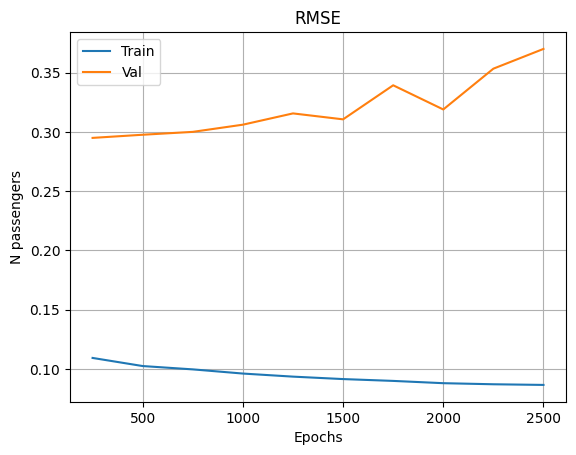

In [305]:
plot_rmse_epochs(list_rmse_train, list_rmse_val)

As said before, once the model is trained, I can get the predictions and keep only the last element of each predicted sequence. Indeed, the first elements of each sequence are the same as the last elements of the input, so I can drop them.

In [306]:
preds = []

model.eval()
with torch.no_grad():
    # Take only last element of the sequences
    y_pred_train = model(X_train)[:, -1, :]

In [307]:
y_pred_val = eval_val(model)

In [308]:
def plot_pred(y_pred_train, y_pred_val):
    x_ticks_val = np.arange(len(train), len(train) + len(val))
    x_ticks_pred_train = np.arange(look_back, len(train))
    x_ticks_pred_val = np.arange(len(train), len(train) + len(val))

    plt.plot(train, c="k", lw=1, label="Train")
    plt.plot(x_ticks_val, val, c="b", label="Val")
    plt.plot(x_ticks_pred_train, y_pred_train, c="r", lw=1, ls="dashed", label="Fitted")
    plt.plot(x_ticks_pred_val, y_pred_val, c="r", label="Predicted")
    plt.grid()
    plt.legend()
    plt.show()

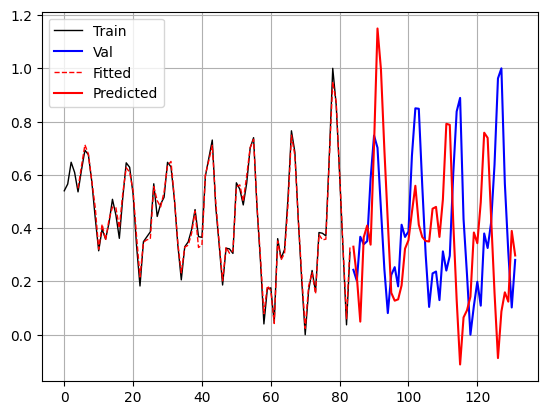

In [309]:
plot_pred(y_pred_train, y_pred_val)

In [310]:
np.sqrt(mean_squared_error(val, y_pred_val))

0.38041705

# (2) Larger look_back

As expected, a small `look_back` leads to inaccurate results. Let's try with a larger `look_back`, or sequence length, to provide more info to the LSTM model, such as trend and seasonal effects.

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([44, 4, 1])) that is different to the input size (torch.Size([48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 250: RMSE_train = 0.07, RMSE_val = 0.32
Epoch 500: RMSE_train = 0.06, RMSE_val = 0.30
Epoch 750: RMSE_train = 0.06, RMSE_val = 0.38
Epoch 1000: RMSE_train = 0.06, RMSE_val = 0.36
Epoch 1250: RMSE_train = 0.05, RMSE_val = 0.33
Epoch 1500: RMSE_train = 0.05, RMSE_val = 0.37
Epoch 1750: RMSE_train = 0.05, RMSE_val = 0.31
Epoch 2000: RMSE_train = 0.05, RMSE_val = 0.30
Epoch 2250: RMSE_train = 0.05, RMSE_val = 0.29
Epoch 2500: RMSE_train = 0.05, RMSE_val = 0.31


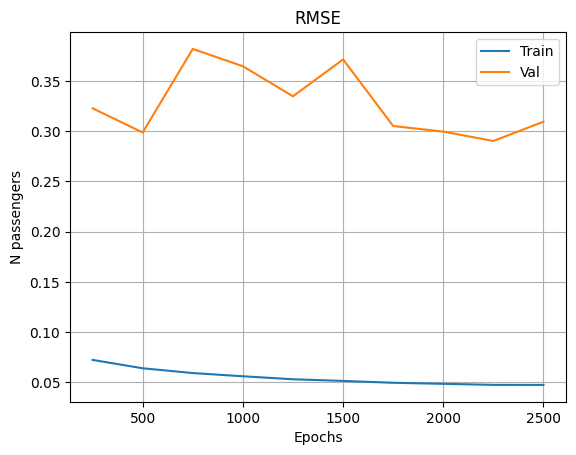

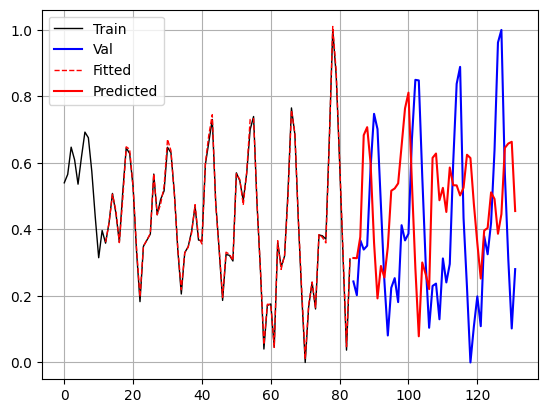

In [311]:
look_back = 12

X_train, y_train = create_dataset(data=train, look_back=look_back)

train_dataloader = DataLoader(
    dataset=TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

model, list_rmse_train, list_rmse_val = train_model(train_dataloader)
plot_rmse_epochs(list_rmse_train, list_rmse_val)

model.eval()
with torch.no_grad():
    # Take only last element of the sequences
    y_pred_train = model(X_train)[:, -1, :]

y_pred_val = eval_val(model)

plot_pred(y_pred_train, y_pred_val)

In [312]:
np.sqrt(mean_squared_error(val, y_pred_val))

0.32890922

# (3) With dropout

In [313]:
look_back = 12

X_train, y_train = create_dataset(data=train, look_back=look_back)

train_dataloader = DataLoader(
    dataset=TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

model, new_list_rmse_train, new_list_rmse_val = train_model(
    train_dataloader=train_dataloader, is_dropout=True
)

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([44, 4, 1])) that is different to the input size (torch.Size([48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 250: RMSE_train = 0.08, RMSE_val = 0.28
Epoch 500: RMSE_train = 0.07, RMSE_val = 0.34
Epoch 750: RMSE_train = 0.06, RMSE_val = 0.37
Epoch 1000: RMSE_train = 0.06, RMSE_val = 0.35
Epoch 1250: RMSE_train = 0.06, RMSE_val = 0.34
Epoch 1500: RMSE_train = 0.06, RMSE_val = 0.37
Epoch 1750: RMSE_train = 0.06, RMSE_val = 0.38
Epoch 2000: RMSE_train = 0.06, RMSE_val = 0.38
Epoch 2250: RMSE_train = 0.06, RMSE_val = 0.37
Epoch 2500: RMSE_train = 0.06, RMSE_val = 0.38


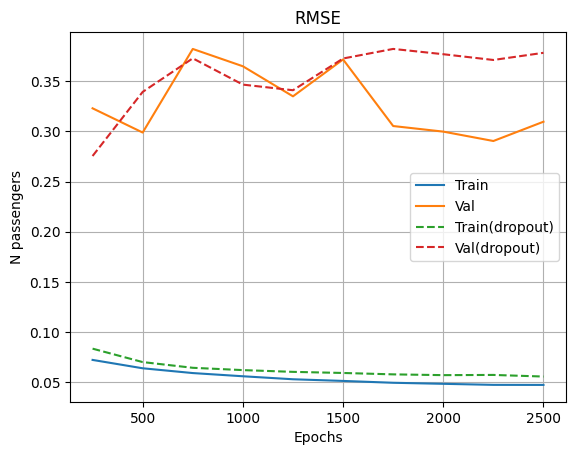

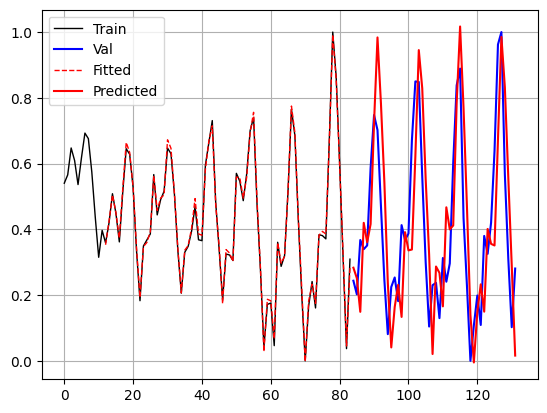

In [ ]:
_, ax = plt.subplots(1, 1)
plot_rmse_epochs(list_rmse_train, list_rmse_val, ax=ax, last=False)
plot_rmse_epochs(new_list_rmse_train, new_list_rmse_val, ax=ax, label="(dropout)")

model.eval()
with torch.no_grad():
    # Take only last element of the sequences
    y_pred_train = model(X_train)[:, -1, :]

y_pred_val = eval_val(model)

plot_pred(y_pred_train, y_pred_val)

In [315]:
np.sqrt(mean_squared_error(val, y_pred_val))

0.1908191

# (4) And back to original data

In [316]:
train_pred = scaler.inverse_transform(y_pred_train) + train_fit[-len(y_pred_train) :]
val_pred = (
    scaler.inverse_transform(y_pred_val.reshape(-1, 1)) + val_fit[-len(y_pred_val) :]
)

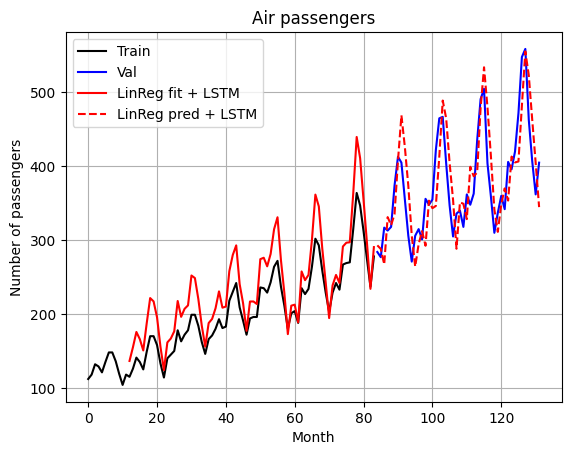

In [317]:
plt.title("Air passengers")
plt.xlabel("Month")
plt.ylabel("Number of passengers")
plt.plot(train_0, color="k", label="Train")
plt.plot(
    np.arange(len(train_0), len(train_0) + len(val_0)), val_0, color="b", label="Val"
)
plt.plot(
    train_months[-len(y_pred_train) :], train_pred, c="r", label="LinReg fit + LSTM"
)
plt.plot(
    val_months[:, 0], val_pred, c="r", linestyle="dashed", label="LinReg pred + LSTM"
)

plt.grid()
plt.legend()
plt.show()

In [318]:
np.sqrt(mean_squared_error(val_0, val_pred))

43.401327305649424